
# StreamWriter Basic Usage

**Author**: [Moto Hira](moto@meta.com)_

This tutorial shows how to use :py:class:`torchaudio.io.StreamWriter` to
encode and save audio/video data into various formats/destinations.


<div class="alert alert-info"><h4>Note</h4><p>This tutorial requires FFmpeg libraries.
   Please refer to `FFmpeg dependency <ffmpeg_dependency>` for
   the detail.</p></div>




<div class="alert alert-danger"><h4>Warning</h4><p>TorchAudio dynamically loads compatible FFmpeg libraries
   installed on the system.
   The types of supported formats (media format, encoder, encoder
   options, etc) depend on the libraries.

   To check the available muxers and encoders, you can use the
   following command

```console
ffmpeg -muxers
ffmpeg -encoders</p></div>
```


## Preparation



In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

from torchaudio.io import StreamWriter

print("FFmpeg library versions")
for k, v in torchaudio.utils.ffmpeg_utils.get_versions().items():
    print(f"  {k}: {v}")

2.1.0+cu118
2.1.0+cu118
FFmpeg library versions
  libavcodec: (58, 134, 100)
  libavdevice: (58, 13, 100)
  libavfilter: (7, 110, 100)
  libavformat: (58, 76, 100)
  libavutil: (56, 70, 100)


In [2]:
import io
import os
import tempfile

from IPython.display import Audio, Video

from torchaudio.utils import download_asset

SAMPLE_PATH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_PATH, channels_first=False)
NUM_FRAMES, NUM_CHANNELS = WAVEFORM.shape

_BASE_DIR = tempfile.TemporaryDirectory()


def get_path(filename):
    return os.path.join(_BASE_DIR.name, filename)

100%|██████████| 106k/106k [00:00<00:00, 2.02MB/s]


## The basic usage

To save Tensor data into media formats with StreamWriter, there
are three necessary steps

1. Specify the output
2. Configure streams
3. Write data

The following code illustrates how to save audio data as WAV file.




In [3]:
# 1. Define the destination. (local file in this case)
path = get_path("test.wav")
s = StreamWriter(path)

In [4]:
# 2. Configure the stream. (8kHz, Stereo WAV)
s.add_audio_stream(
    sample_rate=SAMPLE_RATE,
    num_channels=NUM_CHANNELS,
)

In [5]:
# 3. Write the data
with s.open():
    s.write_audio_chunk(0, WAVEFORM)

In [6]:
Audio(path)

Now we look into each step in more detail.



## Write destination

StreamWriter supports different types of write destinations

1. Local files
2. File-like objects
3. Streaming protocols (such as RTMP and UDP)
4. Media devices (speakers and video players) †

† For media devices, please refer to
[StreamWriter Advanced Usages](./streamwriter_advanced.html)_.




### Local files

StreamWriter supports saving media to local files.


.. code::

   StreamWriter(dst="audio.wav")

   StreamWriter(dst="audio.mp3")

This works for still images and videos as well.

.. code::

   StreamWriter(dst="image.jpeg")

   StreamWriter(dst="video.mpeg")




### File-like objects

You can also pass a file-lie object. A file-like object must implement
``write`` method conforming to :py:attr:`io.RawIOBase.write`.

.. code::

   # Open the local file as fileobj
   with open("audio.wav", "wb") as dst:
       StreamWriter(dst=dst)

.. code::

   # In-memory encoding
   buffer = io.BytesIO()
   StreamWriter(dst=buffer)




### Streaming protocols

You can stream the media with streaming protocols

.. code::

   # Real-Time Messaging Protocol
   StreamWriter(dst="rtmp://localhost:1234/live/app", format="flv")

   # UDP
   StreamWriter(dst="udp://localhost:48550", format="mpegts")




## Configuring output streams

Once the destination is specified, the next step is to configure the streams.
For typical audio and still image cases, only one stream is required,
but for video with audio, at least two streams (one for audio and the other
for video) need to be configured.




### Audio Stream

An audio stream can be added with
:py:meth:`~torchaudio.io.StreamWriter.add_audio_stream` method.

For writing regular audio files, at minimum ``sample_rate`` and ``num_channels``
are required.

.. code::

   s = StreamWriter("audio.wav")
   s.add_audio_stream(sample_rate=8000, num_channels=2)

By default, audio streams expect the input waveform tensors to be ``torch.float32`` type.
If the above case, the data will be encoded into the detault encoding format of WAV format,
which is 16-bit signed integer Linear PCM. StreamWriter converts the sample format internally.

If the encoder supports multiple sample formats and you want to change the encoder sample format,
you can use ``encoder_format`` option.

In the following example, the StreamWriter expects the data type of the input waveform Tensor
to be ``torch.float32``, but it will convert the sample to 16-bit signed integer when encoding.

.. code::

   s = StreamWriter("audio.mp3")
   s.add_audio_stream(
       ...,
       encoder="libmp3lame",   # "libmp3lame" is often the default encoder for mp3,
                               # but specifying it manually, for the sake of illustration.

       encoder_format="s16p",  # "libmp3lame" encoder supports the following sample format.
                               #  - "s16p" (16-bit signed integer)
                               #  - "s32p" (32-bit signed integer)
                               #  - "fltp" (32-bit floating point)
   )

If the data type of your waveform Tensor is something other than ``torch.float32``,
you can provide ``format`` option to change the expected data type.

The following example configures StreamWriter to expect Tensor of ``torch.int16`` type.

.. code::

   # Audio data passed to StreamWriter must be torch.int16
   s.add_audio_stream(..., format="s16")

The following figure illustrates how ``format`` and ``encoder_format`` options work
for audio streams.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/streamwriter-format-audio.png">




### Video Stream

To add a still image or a video stream, you can use
:py:meth:`~torchaudio.io.StreamWriter.add_video_stream` method.

At minimum, ``frame_rate``, ``height`` and ``width`` are required.

.. code::

   s = StreamWriter("video.mp4")
   s.add_video_stream(frame_rate=10, height=96, width=128)

For still images, please use ``frame_rate=1``.

.. code::

   s = StreamWriter("image.png")
   s.add_video_stream(frame_rate=1, ...)

Similar to the audio stream, you can provide ``format`` and ``encoder_format``
option to controll the format of input data and encoding.

The following example encodes video data in YUV422 format.

.. code::

   s = StreamWriter("video.mov")
   s.add_video_stream(
       ...,
       encoder="libx264",  # libx264 supports different YUV formats, such as
                           # yuv420p yuvj420p yuv422p yuvj422p yuv444p yuvj444p nv12 nv16 nv21

       encoder_format="yuv422p",  # StreamWriter will convert the input data to YUV422 internally
   )

YUV formats are commonly used in video encoding. Many YUV formats are composed of chroma
channel of different plane size than that of luma channel. This makes it difficult to
directly express it as ``torch.Tensor`` type.
Therefore, StreamWriter will automatically convert the input video Tensor into the target format.

StreamWriter expects the input image tensor to be 4-D (`time`, `channel`, `height`, `width`)
and ``torch.uint8`` type.

The default color channel is RGB. That is three color channels corresponding red, green and blue.
If your input has different color channel, such as BGR and YUV, you can specify it with
``format`` option.

The following example specifies BGR format.

.. code::

   s.add_video_stream(..., format="bgr24")
                      # Image data passed to StreamWriter must have
                      # three color channels representing Blue Green Red.
                      #
                      # The shape of the input tensor has to be
                      # (time, channel==3, height, width)


The following figure illustrates how ``format`` and ``encoder_format`` options work for
video streams.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/streamwriter-format-video.png">




## Write data

Once streams are configured, the next step is to open the output location
and start writing data.

Use :py:meth:`~torchaudio.io.StreamWriter.open` method to open the
destination, and then write data with :py:meth:`~torchaudio.io.StreamWriter.write_audio_chunk`
and/or :py:meth:`~torchaudio.io.StreamWriter.write_video_chunk`.

Audio tensors are expected to have the shape of `(time, channels)`,
and video/image tensors are expected to have the shape of `(time, channels, height, width)`.

Channels, height and width must match the configuration of the corresponding
stream, specified with ``"format"`` option.

Tensor representing a still image must have only one frame in time dimension,
but audio and video tensors can have arbitral number of frames in time dimension.

The following code snippet illustrates this;




### Ex) Audio




In [7]:
# Configure stream
s = StreamWriter(dst=get_path("audio.wav"))
s.add_audio_stream(sample_rate=SAMPLE_RATE, num_channels=NUM_CHANNELS)

# Write data
with s.open():
    s.write_audio_chunk(0, WAVEFORM)

### Ex) Image




In [8]:
# Image config
height = 96
width = 128

# Configure stream
s = StreamWriter(dst=get_path("image.png"))
s.add_video_stream(frame_rate=1, height=height, width=width, format="rgb24")

# Generate image
chunk = torch.randint(256, (1, 3, height, width), dtype=torch.uint8)

# Write data
with s.open():
    s.write_video_chunk(0, chunk)

### Ex) Video without audio




In [9]:
# Video config
frame_rate = 30
height = 96
width = 128

# Configure stream
s = StreamWriter(dst=get_path("video.mp4"))
s.add_video_stream(frame_rate=frame_rate, height=height, width=width, format="rgb24")

# Generate video chunk (3 seconds)
time = int(frame_rate * 3)
chunk = torch.randint(256, (time, 3, height, width), dtype=torch.uint8)

# Write data
with s.open():
    s.write_video_chunk(0, chunk)

### Ex) Video with audio

To write video with audio, separate streams have to be configured.




In [10]:
# Configure stream
s = StreamWriter(dst=get_path("video.mp4"))
s.add_audio_stream(sample_rate=SAMPLE_RATE, num_channels=NUM_CHANNELS)
s.add_video_stream(frame_rate=frame_rate, height=height, width=width, format="rgb24")

# Generate audio/video chunk (3 seconds)
time = int(SAMPLE_RATE * 3)
audio_chunk = torch.randn((time, NUM_CHANNELS))
time = int(frame_rate * 3)
video_chunk = torch.randint(256, (time, 3, height, width), dtype=torch.uint8)

# Write data
with s.open():
    s.write_audio_chunk(0, audio_chunk)
    s.write_video_chunk(1, video_chunk)

### Writing data chunk by chunk

When writing data, it is possible to split data along time dimension and
write them by smaller chunks.




In [11]:
# Write data in one-go
dst1 = io.BytesIO()
s = StreamWriter(dst=dst1, format="mp3")
s.add_audio_stream(SAMPLE_RATE, NUM_CHANNELS)
with s.open():
    s.write_audio_chunk(0, WAVEFORM)

In [12]:
# Write data in smaller chunks
dst2 = io.BytesIO()
s = StreamWriter(dst=dst2, format="mp3")
s.add_audio_stream(SAMPLE_RATE, NUM_CHANNELS)
with s.open():
    for start in range(0, NUM_FRAMES, SAMPLE_RATE):
        end = start + SAMPLE_RATE
        s.write_audio_chunk(0, WAVEFORM[start:end, ...])

In [13]:
# Check that the contents are same
dst1.seek(0)
bytes1 = dst1.read()

print(f"bytes1: {len(bytes1)}")
print(f"{bytes1[:10]}...{bytes1[-10:]}\n")

dst2.seek(0)
bytes2 = dst2.read()

print(f"bytes2: {len(bytes2)}")
print(f"{bytes2[:10]}...{bytes2[-10:]}\n")

assert bytes1 == bytes2

import matplotlib.pyplot as plt

bytes1: 10701
b'ID3\x04\x00\x00\x00\x00\x00#'...b'\xaa\xaa\xaa\xaa\xaa\xaa\xaa\xaa\xaa\xaa'

bytes2: 10701
b'ID3\x04\x00\x00\x00\x00\x00#'...b'\xaa\xaa\xaa\xaa\xaa\xaa\xaa\xaa\xaa\xaa'



## Example - Spectrum Visualizer

In this section, we use StreamWriter to create a spectrum visualization
of audio and save it as a video file.

To create spectrum visualization, we use
:py:class:`torchaudio.transforms.Spectrogram`, to get spectrum presentation
of audio, generate raster images of its visualization using matplotplib,
then use StreamWriter to convert them to video with the original audio.



In [14]:
import torchaudio.transforms as T

### Prepare Data

First, we prepare the spectrogram data.
We use :py:class:`~torchaudio.transforms.Spectrogram`.

We adjust ``hop_length`` so that one frame of the spectrogram corresponds
to one video frame.




In [15]:
frame_rate = 20
n_fft = 4000

trans = T.Spectrogram(
    n_fft=n_fft,
    hop_length=SAMPLE_RATE // frame_rate,  # One FFT per one video frame
    normalized=True,
    power=1,
)
specs = trans(WAVEFORM.T)[0].T

The resulting spectrogram looks like the following.




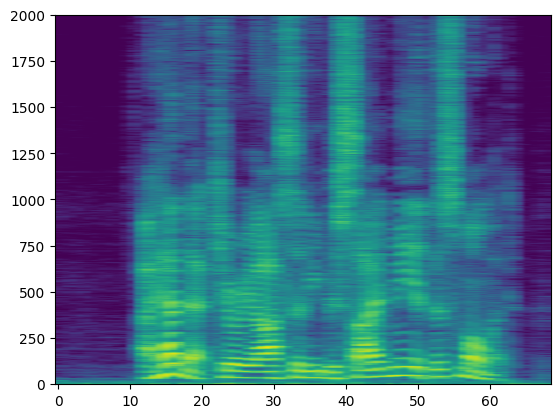

In [16]:
spec_db = T.AmplitudeToDB(stype="magnitude", top_db=80)(specs.T)
_ = plt.imshow(spec_db, aspect="auto", origin="lower")

### Prepare Canvas

We use ``matplotlib`` to visualize the spectrogram per frame.
We create a helper function that plots the spectrogram data and
generates a raster imager of the figure.




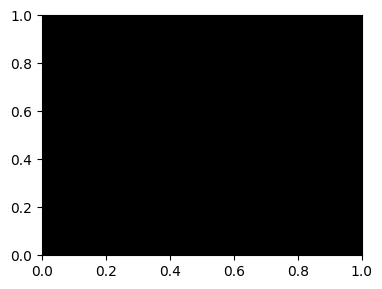

In [17]:
fig, ax = plt.subplots(figsize=[3.2, 2.4])
ax.set_position([0, 0, 1, 1])
ax.set_facecolor("black")
ncols, nrows = fig.canvas.get_width_height()


def _plot(data):
    ax.clear()
    x = list(range(len(data)))
    R, G, B = 238 / 255, 76 / 255, 44 / 255
    for coeff, alpha in [(0.8, 0.7), (1, 1)]:
        d = data**coeff
        ax.fill_between(x, d, -d, color=[R, G, B, alpha])
    xlim = n_fft // 2 + 1
    ax.set_xlim([-1, n_fft // 2 + 1])
    ax.set_ylim([-1, 1])
    ax.text(
        xlim,
        0.95,
        f"Created with TorchAudio\n{torchaudio.__version__}",
        color="white",
        ha="right",
        va="top",
        backgroundcolor="black",
    )
    fig.canvas.draw()
    frame = torch.frombuffer(fig.canvas.tostring_rgb(), dtype=torch.uint8)
    return frame.reshape(nrows, ncols, 3).permute(2, 0, 1)


# sphinx_gallery_defer_figures

### Write Video

Finally, we use StreamWriter and write video.
We process one second of audio and video frames at a time.




In [18]:
s = StreamWriter(get_path("example.mp4"))
s.add_audio_stream(sample_rate=SAMPLE_RATE, num_channels=NUM_CHANNELS)
s.add_video_stream(frame_rate=frame_rate, height=nrows, width=ncols)

with s.open():
    i = 0
    # Process by second
    for t in range(0, NUM_FRAMES, SAMPLE_RATE):
        # Write audio chunk
        s.write_audio_chunk(0, WAVEFORM[t : t + SAMPLE_RATE, :])

        # write 1 second of video chunk
        frames = [_plot(spec) for spec in specs[i : i + frame_rate]]
        if frames:
            s.write_video_chunk(1, torch.stack(frames))
        i += frame_rate

plt.close(fig)

<ipython-input-17-8075156bf554>:27: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:1508.)
  frame = torch.frombuffer(fig.canvas.tostring_rgb(), dtype=torch.uint8)


### Result

The result looks like below.





In [19]:
Video(get_path("example.mp4"), embed=True)

Carefully watching the video, it can be
observed that the sound of "s" (curio\ **si**\ ty, be\ **si**\ des, thi\ **s**\ ) has
more energy allocated on higher frequency side (right side of the video).



Tag: :obj:`torchaudio.io`


